# Deep Energy-Based Generative Models


In [1]:
!nvidia-smi

Tue Dec 21 01:24:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --quiet pytorch-lightning==1.5.0

In [3]:
!pip install --quiet torchsummary

In [4]:
!pip install --quiet torchmetrics[image]

In [5]:
## Standard libraries
import os
import json
import math
import numpy as np 
import random

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torchsummary import summary
# Torchvision
import torchvision
from torchvision.datasets import MNIST, CIFAR10, CelebA
from torchvision import transforms, datasets
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.5.0
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

## Torchmetrics
from torchmetrics import IS, FID

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10, MNIST, CELEBA, RETINA)
DATASET_PATH = "/kaggle/input/celeba-dataset/img_align_celeba" #"/kaggle/input/diabetic-retinopathy-2015-data-colored-resized/colored_images/colored_images"   
DATASET = "CELEBA"
BATCH_SIZE = 128

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/kaggle/input/deep-energy-models/CELEBA/contrastive_divergence/SGLD/lightning_logs/version_0/checkpoints/"
CHECKPOINT_TEST_PATH = "/kaggle/input/"
CHECKPOINT_FILE = ""

#Training hyperparameter
TRAINING_STEPS = 60
TRAINING_STEP_SIZE = 10
MAX_EPOCHS = 1
EVERY_N_EPOCHS = 1
DIVERGENCE = 'contrastive_divergence' # (e.g contrastive_divergence, reverse_kl, kl, pearson_x2, jensen_shannon, squared_hellinger)
MCMC_SAMPLING = 'SGLD' # (e.g SGLD, ASGLD, CYCLIC_SGLD, REPLICA_SGLD, CONTOUR_SGLD)

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

# Initialize IS and FID
inception_metrics = IS().to(device, non_blocking=True)
fid_metrics = FID(feature=2048).to(device, non_blocking=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  del sys.path[0]


Device: cuda


/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `IS` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FID` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [6]:
# if DATASET == 'CELEBA':
#     !mkdir -p /content/data
#     %cp -av '/content/drive/MyDrive/Colab Notebooks/improved_contrastive_divergence.v6/data/celeba' /content/data

# Energy Models


## Dataset


In [7]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = DATASET_PATH):
        super().__init__()
        self.data_dir = data_dir
        # Transformations applied on each image => make them a tensor and normalize between -1 and 1
        self.transform = transforms.Compose(
              [
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,), (0.5,)),
              ]
          )
        self.dims = (1, 28, 28)

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        
        # Loading the training dataset. We need to split it into a training and validation part
        if stage == "fit" or stage is None:
          self.mnist_train = MNIST(self.data_dir, train=True, transform=self.transform)
        
        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
          self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return data.DataLoader(self.mnist_train, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True, num_workers=4)

    def val_dataloader(self):
        return data.DataLoader(self.mnist_test, batch_size=BATCH_SIZE, num_workers=4)

In [8]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = DATASET_PATH):
        super().__init__()
        self.data_dir = data_dir
        # Transformations applied on each image => make them a tensor and normalize between -1 and 1
        self.transform = transforms.Compose(
              [
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5,)),
              ]
          )
        self.dims = (3, 32, 32)
    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=True, download=False)
        CIFAR10(self.data_dir, train=False, download=False)

    def setup(self, stage = None):      
        # Loading the training dataset. We need to split it into a training and validation part
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            self.cifar_train = CIFAR10(self.data_dir, train=True, transform=self.transform)
        
        if stage == "test" or stage is None:
            self.cifar_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return data.DataLoader(self.cifar_train, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True, num_workers=4)

    def val_dataloader(self):
        return data.DataLoader(self.cifar_test, batch_size=BATCH_SIZE, num_workers=4)

In [9]:
class CelebADataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = DATASET_PATH):
        super().__init__()
        self.data_dir = data_dir
        # Transformations applied on each image => make them a tensor and normalize between -1 and 1
        self.transform = transforms.Compose(
              [
                  transforms.Resize(32),
                  transforms.CenterCrop(32),
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5,)),
              ]
          )
        self.dims = (3, 32, 32)
        self.dataset = None
        
    def prepare_data(self):
        # download
#         CelebA(self.data_dir, train=True, download=True)
#         CelebA(self.data_dir, train=False, download=True)
        
        self.dataset = datasets.ImageFolder(self.data_dir, transform=self.transform)
        

    def setup(self, stage = None):      
        test_size = 50000
        train_size = len(self.dataset) - test_size
        train_ds, test_ds = data.random_split(self.dataset, [train_size, test_size])
        
        # Loading the training dataset. We need to split it into a training and validation part
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
#             self.celeba_train = CelebA(self.data_dir, train=True, transform=self.transform)
                self.celeba_train = train_ds
        
        if stage == "test" or stage is None:
#             self.celeba_test = CelebA(self.data_dir, train=False, transform=self.transform)
                self.celeba_test = test_ds

    def train_dataloader(self):
        return data.DataLoader(self.celeba_train, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True, num_workers=2)

    def val_dataloader(self):
        return data.DataLoader(self.celeba_test, batch_size=BATCH_SIZE, num_workers=2)

In [10]:
class RetinaDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = DATASET_PATH):
        super().__init__()
        self.data_dir = data_dir
        # Transformations applied on each image => make them a tensor and normalize between -1 and 1
        self.transform = transforms.Compose(
              [
                  transforms.Resize(64),
                  transforms.CenterCrop(64),
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5,)),
              ]
          )
        self.dims = (3, 64, 64)
        self.dataset = None
        
    def prepare_data(self):

        self.dataset = datasets.ImageFolder(self.data_dir, transform=self.transform)        

    def setup(self, stage = None):      
        test_size = 1280
        train_size = len(self.dataset) - test_size
        train_ds, test_ds = data.random_split(self.dataset, [train_size, test_size])
        
        # Loading the training dataset. We need to split it into a training and validation part
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
                self.retina_train = train_ds
        
        if stage == "test" or stage is None:
                self.retina_test = test_ds

    def train_dataloader(self):
        return data.DataLoader(self.retina_train, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True, num_workers=2)

    def val_dataloader(self):
        return data.DataLoader(self.retina_test, batch_size=BATCH_SIZE, num_workers=2)

## CNN Model


In [11]:
class Swish(nn.Module):    
    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):
    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2
        
        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [12]:
class StandardCNN(nn.Module):
    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features*2 #64
        c_hid2 = hidden_features*4 #128
        c_hid3 = hidden_features*8 #256
        c_hid4 = hidden_features*16 #512
        c_hid5 = hidden_features*32 #1028

        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(3, c_hid1, 3, 1, 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(c_hid1, c_hid1, 4, 2, 1))

        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(c_hid1, c_hid2, 3, 1, 1))
        self.conv4 = nn.utils.spectral_norm(nn.Conv2d(c_hid2, c_hid2, 4, 2, 1))

        self.conv5 = nn.utils.spectral_norm(nn.Conv2d(c_hid2, c_hid3, 3, 1, 1))
        self.conv6 = nn.utils.spectral_norm(nn.Conv2d(c_hid3, c_hid3, 4, 2, 1))

        self.conv7 = nn.utils.spectral_norm(nn.Conv2d(c_hid3, c_hid4, 3, 1, 1))
        self.conv8 = nn.utils.spectral_norm(nn.Conv2d(c_hid4, c_hid4, 4, 2, 1))
        
        self.conv9 = nn.utils.spectral_norm(nn.Conv2d(c_hid4, c_hid5, 3, 1, 1))

        self.act = nn.SiLU(inplace=True)
        self.dense = nn.utils.spectral_norm(nn.Linear(c_hid3 * 4 * 4, out_dim))

    def forward(self, x):

        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))
        x = self.act(self.conv4(x))
        x = self.act(self.conv5(x))
        x = self.act(self.conv6(x))
        x = self.act(self.conv7(x))
        x = self.act(self.conv8(x))
        x = self.act(self.conv9(x))

        x = self.dense(x.view(x.shape[0], -1))

        return x

In [13]:
class WSConv2D(nn.Conv2d):
    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride = 1, padding = 0,
        dilation = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros'):

        super(WSConv2D, self).__init__(in_channels, out_channels, kernel_size, stride, 
            padding, dilation, groups, bias, padding_mode)
        
        nn.init.xavier_normal_(self.weight)
        self.gain = nn.Parameter(torch.ones(self.out_channels, 1, 1, 1))
        self.register_buffer('eps', torch.tensor(1e-4, requires_grad=False), persistent=False)
        self.register_buffer('fan_in', torch.tensor(self.weight.shape[1:].numel(), requires_grad=False).type_as(self.weight), persistent=False)

    def standardized_weights(self):
        # Original code: HWCN
        mean = torch.mean(self.weight, axis=[1,2,3], keepdims=True)
        var = torch.var(self.weight, axis=[1,2,3], keepdims=True)
        scale = torch.rsqrt(torch.maximum(var * self.fan_in, self.eps))
        return (self.weight - mean) * scale * self.gain
        
    def forward(self, x):
        return F.conv2d(
            input=x,
            weight=self.standardized_weights(),
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups
        )

In [14]:
class ResBlock(nn.Module):
    def __init__(self, channel, n_class=None, downsample=True, rescale=True):
        super().__init__()
        #add spectral normalization to all layers of the model
        self.conv1 = nn.utils.spectral_norm(
            nn.Conv2d(
                channel,
                channel,
                kernel_size=3, 
                stride=1, 
                padding=1
            )
        )

        self.conv2 = nn.utils.spectral_norm(
            nn.Conv2d(
                channel,
                channel,
                kernel_size=3, 
                stride=1, 
                padding=1
            )
        )

        self.class_embed = None

        if n_class is not None:
            class_embed = nn.Embedding(n_class, channel * 2 * 2)
            class_embed.weight.data[:, : channel * 2] = 1
            class_embed.weight.data[:, channel * 2 :] = 0

            self.class_embed = class_embed

        self.skip = None

        if downsample:
            if rescale:
                self.skip = nn.Sequential(
                    nn.utils.spectral_norm(nn.Conv2d(channel, 2*channel, kernel_size=3, stride=1, padding=1))
                )
            else:
                self.skip = nn.Sequential(
                    nn.utils.spectral_norm(nn.Conv2d(channel, channel, kernel_size=3, stride=1, padding=1))
                )
        
        self.downsample = downsample
#         self.bn = nn.InstanceNorm2d(channel, affine=True)
        self.act = nn.SiLU()
        self.avg_pool = nn.AvgPool2d(3, stride=2, padding=1)

    def forward(self, input, class_id=None):
        out = input

        out = self.conv1(out)
#         out = self.bn(out)

        if self.class_embed is not None:
            embed = self.class_embed(class_id).view(input.shape[0], -1, 1, 1)
            weight1, weight2, bias1, bias2 = embed.chunk(4, 1)
            out = weight1 * out + bias1

        out = self.act(out)

        out = self.conv2(out)
#         out = self.bn(out)

        if self.class_embed is not None:
            out = weight2 * out + bias2
        
        out = out + input
        out = self.act(out)
        
        if self.downsample:
            out = self.skip(out)
            out = self.act(self.avg_pool(out))

        return out



In [15]:
class CelebAModel(nn.Module):
    def __init__(self, n_class=None):
        super().__init__()
        #add spectral normalization to all layers of the model
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

        self.res_1a = ResBlock(64,  n_class, downsample=False)
        self.res_1b = ResBlock(64,  n_class, downsample=True, rescale=False)
        
        self.res_2a = ResBlock(64,  n_class, downsample=False)
        self.res_2b = ResBlock(64,  n_class, downsample=True, rescale=True)
        
        self.res_3a = ResBlock(128, n_class, downsample=False)
        self.res_3b = ResBlock(128, n_class, downsample=True, rescale=True)
        
        self.res_4a = ResBlock(256, n_class, downsample=False)
        self.res_4b = ResBlock(256, n_class, downsample=True, rescale=True)

        self.linear = nn.Linear(512, 1)
        self.act = nn.SiLU()

    def forward(self, input, class_id=None):
        out = self.conv1(input)

        out = self.act(out)

        out = self.res_1a(out)
        out = self.res_1b(out)
        
        out = self.res_2a(out)
        out = self.res_2b(out)
        
        out = self.res_3a(out)
        out = self.res_3b(out)
        
        out = self.res_4a(out)
        out = self.res_4b(out)
        
        out = self.act(out)
        out = out.view(out.shape[0], out.shape[1], -1).sum(2)
#         out = out.mean(dim=2).mean(dim=2)

#         out = out.view(out.shape[0], -1)
        out = self.linear(out)

        return out

In [16]:
class CondResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, n_class=None, downsample=False):
        super().__init__()
        #add spectral normalization to all layers of the model
        self.conv1 = WSConv2D(
            in_channel,
            out_channel,
            3,
            padding=1,
            bias=False if n_class is not None else True,
        )
        

        self.conv2 = WSConv2D(
            out_channel,
            out_channel,
            3,
            padding=1,
            bias=False if n_class is not None else True,
        )
        

        self.class_embed = None

        if n_class is not None:
            class_embed = nn.Embedding(n_class, out_channel * 2 * 2)
            class_embed.weight.data[:, : out_channel * 2] = 1
            class_embed.weight.data[:, out_channel * 2 :] = 0

            self.class_embed = class_embed

        self.skip = None

        if in_channel != out_channel or downsample:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 1, bias=False)
            )

        self.downsample = downsample

    def forward(self, input, class_id=None):
        out = input

        out = self.conv1(out)

        if self.class_embed is not None:
            embed = self.class_embed(class_id).view(input.shape[0], -1, 1, 1)
            weight1, weight2, bias1, bias2 = embed.chunk(4, 1)
            out = weight1 * out + bias1

        out = F.leaky_relu(out, negative_slope=0.2)

        out = self.conv2(out)

        if self.class_embed is not None:
            out = weight2 * out + bias2

        if self.skip is not None:
            skip = self.skip(input)

        else:
            skip = input

        out = out + skip

        if self.downsample:
            out = F.avg_pool2d(out, 2)

        out = F.leaky_relu(out, negative_slope=0.2)

        return out

class ResNetV2Model(nn.Module):
    def __init__(self, n_class=None):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)

        self.blocks = nn.ModuleList(
            [
                CondResBlock(128, 128, n_class, downsample=True),
                CondResBlock(128, 128, n_class),
                CondResBlock(128, 256, n_class, downsample=True),
                CondResBlock(256, 256, n_class),
                CondResBlock(256, 256, n_class, downsample=True),
                Self_Attn(256),
                CondResBlock(256, 512, n_class),
            ]
        )

        self.linear = nn.Linear(512, 1)
        self.act = Swish()

    def forward(self, input, class_id=None):
        out = self.conv1(input)

        out = self.act(out)

        for block in self.blocks:
            out = block(out, class_id)

        out = self.act(out)
        out = out.view(out.shape[0], out.shape[1], -1).sum(2)
        out = self.linear(out)

        return out
    
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #

    def forward(self, x, class_id=None):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)

        out = self.gamma*out + x
        return out

## Sampling buffer


In [17]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, sampling,max_len=10000):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]
        self.sampling = sampling

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        if self.sampling == "CYCLIC_SGLD":
            inp_imgs = Sampler.generate_cyclic_sgld_samples(self.model, inp_imgs, steps=steps, step_size=step_size)
        elif self.sampling == "REPLICA_SGLD":
            inp_imgs = Sampler.generate_replica_sgld_samples(self.model, inp_imgs, steps=steps, step_size=step_size)
        elif self.sampling == "CONTOUR_SGLD":
            inp_imgs = Sampler.generate_contour_sgld_samples(self.model, inp_imgs, steps=steps, step_size=step_size)
        elif self.sampling == "SGLD":
            inp_imgs = Sampler.generate_sgld_samples(self.model, inp_imgs, steps=steps, step_size=step_size)
        elif self.sampling == "ASGLD":
            inp_imgs = Sampler.generate_asgld_samples(self.model, inp_imgs, steps=steps, step_size=step_size)
        else:
            assert False

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_sgld_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model. 
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input. 
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True
        
        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)
        
        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)
        
        # List for storing generations at each step (for later analysis)
        imgs_per_step = []
        
        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            
            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())
        
        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        
        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs
    
    @staticmethod
    def generate_asgld_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model. 
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input. 
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True
        
        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)
        
        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = 0.1
        
        # List for storing generations at each step (for later analysis)
        imgs_per_step = []
        
        # Adaptively preconditioned SGLD
        mean = torch.zeros_like(inp_imgs.data)
        variance = torch.zeros_like(inp_imgs.data)
        std = torch.zeros_like(inp_imgs.data)
        momentum = 0.9
        eps = 1e-6
        
        # Loop over K (steps)
        for _ in range(steps):
            # Getting mean,std at previous step
            old_mean = mean.clone()
            old_std = std.clone()
            
            # Part 1: Add noise to the input.
            new_updt = torch.normal(mean=old_mean, std=old_std)
            inp_imgs.data.add_(noise * new_updt)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients
            
            # Updating mean
            mean = mean.mul(momentum).add(inp_imgs)

            part_var1 = inp_imgs.data.add(-old_mean)
            part_var2 = inp_imgs.data.add(-mean)

            new_std = torch.pow(old_std,2).mul(momentum).addcmul(1,part_var1,part_var2).add(eps)                
            new_std = torch.pow(torch.abs_(new_std),1/2)
            std.add_(-1,std).add_(new_std)

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            
            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())
        
        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        
        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs
        
    @staticmethod
    def generate_sghmc_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model. 
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input. 
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True
        
        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)
        
        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
#         noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)
        
        # List for storing generations at each step (for later analysis)
        imgs_per_step = []
        
        tau = torch.ones_like(inp_imgs)
        g = torch.ones_like(inp_imgs)
        V_hat = torch.ones_like(inp_imgs)
        v_momentum = torch.ones_like(inp_imgs)
        base_C = 0.05
        eps = 1e-6
        
        # Loop over K (steps)
        for i in range(steps):
            V_sqrt = torch.sqrt(V_hat)
            V_inv_sqrt = 1. / (V_sqrt + eps)  # preconditioner
            
            noise_var = (2. * (step_size ** 2) * V_inv_sqrt * base_C - (step_size ** 4))
            noise_std = torch.sqrt(torch.clamp(noise_var, min=1e-16))
            
            # Part 1: Add noise to the input.
            noise_sample = torch.normal(mean=torch.zeros_like(inp_imgs), std=torch.ones_like(inp_imgs) * noise_std)
            inp_imgs.data.add_(noise_sample.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients
            
            if i < 20:  # We update g first as it makes most sense
                tau.add_(-tau * (g ** 2) / (
                            V_hat + eps) + 1)  # specifies the moving average window, see Eq 9 in [1] left
                tau_inv = 1. / (tau + eps)
                g.add_(-tau_inv * g + tau_inv * inp_imgs.grad.data)  # average gradient see Eq 9 in [1] right
                V_hat.add_(-tau_inv * V_hat + tau_inv * (inp_imgs.grad.data ** 2))  # gradient variance see Eq 8 in [1]
                
            # Apply gradients to our current samples
            v_momentum.add_(- (step_size ** 2) * V_inv_sqrt * inp_imgs.grad.data - base_C * v_momentum)
            inp_imgs.data.add_(v_momentum)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            
            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())
        
        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        
        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs
        
    @staticmethod
    def generate_cyclic_sgld_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model. 
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input. 
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True
        
        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)
        
        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)
        
        # List for storing generations at each step (for later analysis)
        imgs_per_step = []
        
        cycles=2
        # Loop over K (steps)
        for i in range(1, steps+1):            
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients
            
            # Cyclical parameter
            sub_total = steps / cycles
            r_remainder = (i % sub_total) * 1.0 / sub_total
            cyc_lr = step_size * 5 / 2 * (math.cos(math.pi * r_remainder) + 1)
            
            # Apply gradients to our current samples
            inp_imgs.data.add_(-cyc_lr * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            
            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())
        
        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        
        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs
    
    @staticmethod
    def generate_replica_sgld_samples(model, inp_low_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model. 
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input. 
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        
        inp_high_imgs = inp_low_imgs.clone()
        
        inp_low_imgs.requires_grad = True
        inp_high_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)
        
        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise_low = torch.randn(inp_low_imgs.shape, device=inp_low_imgs.device)
        noise_high = torch.randn(inp_low_imgs.shape, device=inp_low_imgs.device)
        
        # List for storing generations at each step (for later analysis)
        imgs_per_step = []
        
        #initialize resgld
        T_multiply = 3
        var = 0.1
        T = 1.0

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the low input.
            noise_low.normal_(0, 0.003)
            noise_high.normal_(0, 0.003 * T_multiply)
            inp_low_imgs.data.add_(noise_low.data)
            inp_high_imgs.data.add_(noise_high.data)
            inp_low_imgs.data.clamp_(min=-1.0, max=1.0)
            inp_high_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current low input.
            out_low_imgs = -model(inp_low_imgs)
            out_high_imgs = -model(inp_high_imgs)
            out_low_imgs.sum().backward()
            out_high_imgs.sum().backward()
            inp_low_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients
            inp_high_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_low_imgs.data.add_(-step_size * inp_low_imgs.grad.data)
            inp_high_imgs.data.add_(-step_size * inp_high_imgs.grad.data)
            inp_low_imgs.data.clamp_(min=-1.0, max=1.0)
            inp_high_imgs.data.clamp_(min=-1.0, max=1.0)

            dT = (1 / T) - (1 / (T * T_multiply))
            swap_rate = torch.exp(dT * (inp_low_imgs.grad.data - inp_high_imgs.grad.data - dT * var))
            intensity_r = 0.1

            inp_high_imgs.grad.detach_()
            inp_high_imgs.grad.zero_()
            inp_low_imgs.grad.detach_()
            inp_low_imgs.grad.zero_()

            if np.random.uniform(0, 1) < intensity_r * swap_rate.mean().item():
                inp_high_imgs, inp_low_imgs = inp_low_imgs, inp_high_imgs

            if return_img_per_step:
                imgs_per_step.append(inp_low_imgs.clone().detach())
            
        
        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        
        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_low_imgs

    @staticmethod
    def generate_contour_sgld_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model. 
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input. 
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True
        
        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)
        
        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)
        
        # List for storing generations at each step (for later analysis)
        imgs_per_step = []
        
        grad_mul = 1.0
        parts = 100
        J = parts - 1
        grad_mul = 1.
        Gcum = np.array(range(parts, 0, -1)) * 1.0 / sum(range(parts, 0, -1))
        decay_lr = 3e-1
        zeta = 0.75
        T = 1.0
        lower_bound, upper_bound = -7., 17.
        div_f = (upper_bound - lower_bound) / parts

        # Loop over K (steps)
        for i in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # lower_bound, upper_bound = torch.min(inp_imgs.grad.data).item() - 1, torch.max(inp_imgs.grad.data).item() + 1
            # div_f = (upper_bound - lower_bound) / parts
            grad_mul = 1 + zeta * T * (np.log(Gcum[J]) - np.log(Gcum[J-1])) / div_f
            J = min(max(int((inp_imgs.grad.data.mean() - lower_bound) / div_f + 1), 1), parts - 1)

            lr = min(decay_lr, 10./(i**0.8+100))

            Gcum[:J] = Gcum[:J] + lr * Gcum[J]**zeta * (-Gcum[:J])
            Gcum[J] = Gcum[J] + lr * Gcum[J]**zeta * (1 - Gcum[J])
            Gcum[(J+1):] = Gcum[(J+1):] + lr * Gcum[J]**zeta * (-Gcum[(J+1):])
            
            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * grad_mul * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())
        
        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        
        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

## Training algorithm


### Model

In [18]:
class DeepEnergyModel(pl.LightningModule):
    
    def __init__(self, img_shape, batch_size, divergence, mcmc_sampling,alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()
        
        self.cnn = CNNModel(**CNN_args) if img_shape[0] == 1 else ResNetV2Model(**CNN_args)
        
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size, sampling=mcmc_sampling)
        self.example_input_array = torch.zeros(1, *img_shape)
        self.last_real_imgs = torch.rand((batch_size,) + img_shape)
        self.last_fake_imgs = torch.rand((batch_size,) + img_shape)
        self.divergence = divergence
 
    def forward(self, x):
        z = self.cnn(x)
        return z

    def stable_exp(self, x):
        return torch.exp(torch.clip(x, min=-5., max=5.))

    def grad_exp(self, x):
        if self.divergence == 'reverse_kl':
            return - self.stable_exp(-x)
        elif self.divergence == 'kl':
            return 1 + x
        elif self.divergence == 'pearson_x2':
            return 2. * (self.stable_exp(x) - 1)
        elif self.divergence == 'jensen_shannon':
            return torch.log(torch.tensor(2.)) + x - torch.log(1 + self.stable_exp(x))
        elif self.divergence == 'squared_hellinger':
            return 1. - self.stable_exp(-0.5 * x)
        else:
            assert False

    def conjugate_grad_exp(self, x):
        if self.divergence == 'reverse_kl':
            return -1. + x
        elif self.divergence == 'kl':
            return self.stable_exp(x)
        elif self.divergence == 'pearson_x2':
            return self.stable_exp(2. * x) - 1
        elif self.divergence == 'jensen_shannon':
            return -torch.log(torch.tensor(2.)) + torch.log(1 + self.stable_exp(x))
        elif self.divergence == 'squared_hellinger':
            return self.stable_exp(0.5 * x) - 1
        else:
            assert False
    
    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters. 
        # Hence, we set it to 0 by default. 
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
        real_imgs, _ = batch
        self.last_real_imgs = real_imgs.detach()
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)
        
#         train_steps = np.random.choice([20,40,60])
        # Obtain samples
        fake_imgs = self.sampler.sample_new_exmps(steps=TRAINING_STEPS, step_size=TRAINING_STEP_SIZE)
        self.last_fake_imgs = fake_imgs.detach()
        
        # Calculate FID and IS every 500 iterations
        #if self.current_epoch * len(val_dl) + batch_idx % 500 == 0 :
    
        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)
        
        # Calculate losses
        reg_loss = 0.
        cdiv_loss = 0.
        f_div_loss = 0.
        if self.divergence == 'contrastive_divergence':
            reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
            cdiv_loss = fake_out.mean() - real_out.mean()
            loss = reg_loss + cdiv_loss
        else:
            f_div_loss = -(torch.mean(self.grad_exp(real_out)) + 
                                       torch.mean(self.conjugate_grad_exp(fake_out).detach() * fake_out) - 
                                       torch.mean(self.conjugate_grad_exp(fake_out)) - 
                                       torch.mean(fake_out) * torch.mean(self.conjugate_grad_exp(fake_out)).detach())
            loss = f_div_loss 
        
        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('loss_f_divergence', f_div_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1
        
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)
        
        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

### Callbacks


In [19]:
class GenerateCallback(pl.Callback):

    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=5):
        super().__init__()
        self.batch_size = batch_size         # Number of images to generate
        self.vis_steps = vis_steps           # Number of steps within generation to visualize
        self.num_steps = num_steps           # Number of steps to take during generation
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        # Skip for all other epochs
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Generate images
            imgs_per_step = self.generate_imgs(pl_module)
            # Plot and add to tensorboard
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
                grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1))
                # grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True)
                trainer.logger.experiment.add_image(f"generation_{i}", grid, global_step=trainer.current_epoch)
                torchvision.utils.save_image(grid,f"generation_{i}.png")
                
    def generate_imgs(self, pl_module):
        pl_module.eval()
        start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
        start_imgs = start_imgs * 2 - 1
        torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary
        if MCMC_SAMPLING  == "CYCLIC_SGLD":
            imgs_per_step = Sampler.generate_cyclic_sgld_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=TRAINING_STEP_SIZE, return_img_per_step=True)
        elif MCMC_SAMPLING  == "REPLICA_SGLD":
            imgs_per_step = Sampler.generate_replica_sgld_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=TRAINING_STEP_SIZE, return_img_per_step=True)
        elif MCMC_SAMPLING == "CONTOUR_SGLD":
            imgs_per_step = Sampler.generate_contour_sgld_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=TRAINING_STEP_SIZE, return_img_per_step=True)
        elif MCMC_SAMPLING == "SGLD":
            imgs_per_step = Sampler.generate_sgld_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=TRAINING_STEP_SIZE, return_img_per_step=True)
        elif MCMC_SAMPLING == "ASGLD":
            imgs_per_step = Sampler.generate_asgld_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=TRAINING_STEP_SIZE, return_img_per_step=True)
        else:
            assert False
            
#         imgs_per_step = Sampler.generate_contour_sgld_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=TRAINING_STEP_SIZE, return_img_per_step=True)
        torch.set_grad_enabled(False)
        pl_module.train()
        return imgs_per_step

In [20]:
class SamplerCallback(pl.Callback):
    
    def __init__(self, num_imgs=64, every_n_epochs=5):
        super().__init__()
        self.num_imgs = num_imgs             # Number of images to plot
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)
        
    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k=self.num_imgs), dim=0)
            grid = torchvision.utils.make_grid(exmp_imgs, nrow=8, normalize=True, range=(-1,1))
            # grid = torchvision.utils.make_grid(exmp_imgs, nrow=8, normalize=True)
            trainer.logger.experiment.add_image("sampler", grid, global_step=trainer.current_epoch)
            torchvision.utils.save_image(grid,f"sampler{trainer.current_epoch}.png")

In [21]:
class OutlierCallback(pl.Callback):
    
    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size
    
    def on_epoch_end(self, trainer, pl_module):
        with torch.no_grad():
            pl_module.eval()
            rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            rand_imgs = rand_imgs * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()
        
        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step=trainer.current_epoch)

In [22]:
class ImageMetricsCallback(pl.Callback):
    
    def __init__(self,  num_imgs=64, every_n_epochs=5):
        super().__init__()
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)
        self.num_imgs = num_imgs   

    def rescale_img(self, image):
        image = np.clip(image, -1, 1)
        return torch.from_numpy((np.clip(image * 256, 0, 255)).astype(np.uint8))
    
    def on_train_epoch_end(self, trainer, pl_module):
        # images,_ = next(iter(train_loader))
        if trainer.current_epoch % self.every_n_epochs == 0:
            real_imgs = pl_module.last_real_imgs
            fake_imgs = pl_module.last_fake_imgs
            
            #calculate inception score
            if real_imgs.shape[1] == 1:
                real_imgs = torch.cat((real_imgs, real_imgs, real_imgs), dim=1)
                fake_imgs = torch.cat((fake_imgs, fake_imgs, fake_imgs), dim=1)

            real_imgs = self.rescale_img(real_imgs.cpu().numpy())
            fake_imgs = self.rescale_img(fake_imgs.cpu().numpy())

            real_imgs = real_imgs.to(pl_module.device)
            fake_imgs = fake_imgs.to(pl_module.device)

            inception_metrics.update(fake_imgs)
            inception_mean, inception_std = inception_metrics.compute()
            trainer.logger.experiment.add_scalar("inception_mean", inception_mean.item(), global_step=trainer.current_epoch)
            trainer.logger.experiment.add_scalar("inception_std", inception_std.item(), global_step=trainer.current_epoch)

            #calculate FID
            fid_metrics.update(real_imgs, real=True)
            fid_metrics.update(fake_imgs, real=False)
            fid_val = fid_metrics.compute()
            trainer.logger.experiment.add_scalar("fid_value", fid_val.item(), global_step=trainer.current_epoch)
        

### TensorBoard


In [23]:
# Import tensorboard
# %load_ext tensorboard

In [24]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
# %tensorboard --logdir runs

### Running the model


In [25]:
MAX_NUM_STEPS = 256
if DATASET == 'MNIST':
    data_module = MNISTDataModule()
elif DATASET == 'CIFAR10':
    data_module = CIFAR10DataModule()
elif DATASET == 'CELEBA':
    data_module = CelebADataModule()
elif DATASET == 'RETINA':
    data_module = RetinaDataModule()
else:
    assert False

data_module.prepare_data()
data_module.setup()

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


In [26]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    # ModelCheckpoint(save_weights_only=True, mode="min", monitor='val_contrastive_divergence')
    trainer = pl.Trainer(default_root_dir=os.path.join(DATASET, DIVERGENCE, MCMC_SAMPLING),
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=MAX_EPOCHS+1,
                         gradient_clip_val=0.1,
                         callbacks=[ModelCheckpoint(),
                                    GenerateCallback(every_n_epochs=EVERY_N_EPOCHS),
                                    SamplerCallback(num_imgs=BATCH_SIZE,every_n_epochs=EVERY_N_EPOCHS),
                                    OutlierCallback(),
                                    ImageMetricsCallback(every_n_epochs=EVERY_N_EPOCHS),
                                    LearningRateMonitor("epoch")
                                   ],
                        progress_bar_refresh_rate=1)
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, CHECKPOINT_FILE)
    pretrained_test_filename = os.path.join(CHECKPOINT_TEST_PATH, CHECKPOINT_FILE)
    if os.path.isfile(pretrained_test_filename):
        print("Found pretrained test model, loading...")
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(**kwargs)
        if os.path.isfile(pretrained_filename):        
            trainer.fit(model=model, datamodule=data_module, ckpt_path=pretrained_filename)
        else:
            trainer.fit(model=model, datamodule=data_module)
        
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # No testing as we are more interested in other properties
    return model

In [27]:
model = train_model(divergence=DIVERGENCE,
                    img_shape=data_module.dims,
                    mcmc_sampling=MCMC_SAMPLING,
                    batch_size=BATCH_SIZE,
                    lr=1e-4,
                    beta1=0.0)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been ca

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [28]:
summary(model.to(device), input_size=data_module.dims)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
             Swish-2          [-1, 128, 32, 32]               0
          WSConv2D-3          [-1, 128, 32, 32]         147,584
          WSConv2D-4          [-1, 128, 32, 32]         147,584
            Conv2d-5          [-1, 128, 32, 32]          16,384
      CondResBlock-6          [-1, 128, 16, 16]               0
          WSConv2D-7          [-1, 128, 16, 16]         147,584
          WSConv2D-8          [-1, 128, 16, 16]         147,584
      CondResBlock-9          [-1, 128, 16, 16]               0
         WSConv2D-10          [-1, 256, 16, 16]         295,168
         WSConv2D-11          [-1, 256, 16, 16]         590,080
           Conv2d-12          [-1, 256, 16, 16]          32,768
     CondResBlock-13            [-1, 256, 8, 8]               0
         WSConv2D-14            [-1, 25

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


## Analysis

In the last part of the notebook, we will try to take the trained energy-based generative model, and analyse its properties.

### Image Generation


In [29]:
model.to(device)
pl.seed_everything(43)
callback = GenerateCallback(batch_size=8, vis_steps=8, num_steps=MAX_NUM_STEPS)
imgs_per_step = callback.generate_imgs(model)
imgs_per_step = imgs_per_step.cpu()

The characteristic of sampling with energy-based models is that they require the iterative MCMC algorithm. To gain an insight in how the images change over iterations, we plot a few intermediate samples in the MCMC as well:

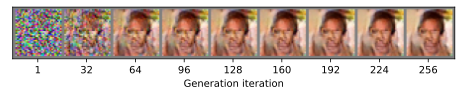

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


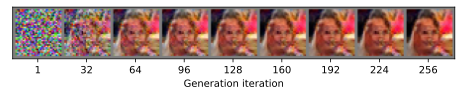

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


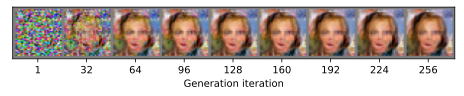

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


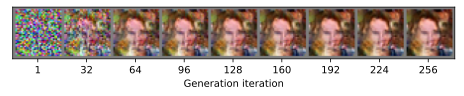

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


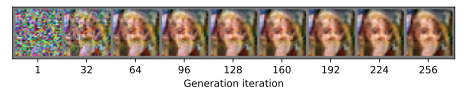

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


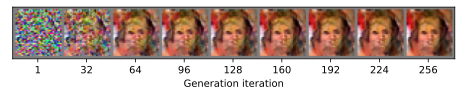

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


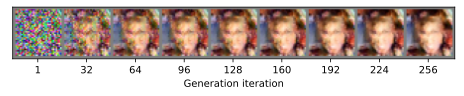

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


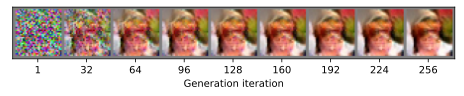

In [30]:
for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)], 
               labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()

### Out-of-distribution detection

A very common and strong application of energy-based models is out-of-distribution detection (sometimes referred to as "anomaly" detection). As more and more deep learning models are applied in production and applications, a crucial aspect of these models is to know what the models don't know. Deep learning models are usually overconfident, meaning that they classify even random images sometimes with 100% probability. Clearly, this is not something that we want to see in applications. Energy-based models can help with this problem because they are trained to detect images that do not fit the training dataset distribution. Thus, in those applications, you could train an energy-based model along with the classifier, and only output predictions if the energy-based models assign a (unnormalized) probability higher than $\delta$ to the image. You can actually combine classifiers and energy-based objectives in a single model, as proposed in this [paper](https://arxiv.org/abs/1912.03263).

In this part of the analysis, we want to test the out-of-distribution capability of our energy-based model. Remember that a lower output of the model denotes a low probability. Thus, we hope to see low scores if we enter random noise to the model:

In [31]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + model.hparams.img_shape).to(model.device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = model.cnn(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item():4.2f}")

Average score for random images: -2.40


As we hoped, the model assigns very low probability to those noisy images. As another reference, let's look at predictions for a batch of images from the training set:

In [32]:
with torch.no_grad():
    train_imgs,_ = next(iter(data_module.val_dataloader()))
    train_imgs = train_imgs.to(model.device)
    train_out = model.cnn(train_imgs).mean()
    print(f"Average score for training images: {train_out.item():4.2f}")

Average score for training images: 0.02


The scores are close to 0 because of the regularization objective that was added to the training. So clearly, the model can distinguish between noise and real digits. However, what happens if we change the training images a little, and see which ones gets a very low score?

In [33]:
@torch.no_grad()
def compare_images(img1, img2):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model.cnn(imgs).cpu().chunk(2, dim=0)
    grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, range=(-1,1), pad_value=0.5, padding=2)
#     grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2]+2)*(0.5+j) for j in range(2)],
               labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()
    print("Score original image: %4.2f" % score1)
    print("Score transformed image: %4.2f" % score2)

We use a random test image for this. Feel free to change it to experiment with the model yourself.

In [34]:
test_imgs, _ = next(iter(data_module.val_dataloader()))
exmp_img = test_imgs[0].to(model.device)

The first transformation is to add some random noise to the image:

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


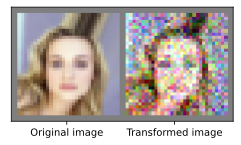

Score original image: -0.04
Score transformed image: -0.36


In [35]:
img_noisy = exmp_img + torch.randn_like(exmp_img) * 0.3
img_noisy.clamp_(min=-1.0, max=1.0)
compare_images(exmp_img, img_noisy)

We can see that the score considerably drops. Hence, the model can detect random Gaussian noise on the image. This is also to expect as initially, the "fake" samples are pure noise images.

Next, we flip an image and check how this influences the score:

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


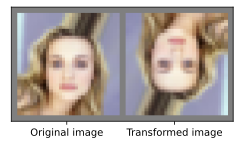

Score original image: -0.04
Score transformed image: -0.05


In [36]:
img_flipped = exmp_img.flip(dims=(1,2))
compare_images(exmp_img, img_flipped)

If the digit can only be read in this way, for example, the 7, then we can see that the score drops. However, the score only drops slightly. This is likely because of the small size of our model. Keep in mind that generative modeling is a much harder task than classification, as we do not only need to distinguish between classes but learn **all** details/characteristics of the digits. With a deeper model, this could eventually be captured better (but at the cost of greater training instability).

Finally, we check what happens if we reduce the digit significantly in size:

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


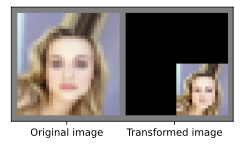

Score original image: -0.04
Score transformed image: 0.08


In [37]:
img_tiny = torch.zeros_like(exmp_img)-1
img_tiny[:,exmp_img.shape[1]//2:,exmp_img.shape[2]//2:] = exmp_img[:,::2,::2]
compare_images(exmp_img, img_tiny)

The score again drops but not by a large margin, although digits in the MNIST dataset usually are much larger. 

Overall, we can conclude that our model is good for detecting Gaussian noise and smaller transformations to existing digits. Nonetheless, to obtain a very good out-of-distribution model, we would need to train deeper models and for more iterations.

### Instability

Finally, we should discuss the possible instabilities of energy-based models, in particular for the example of image generation that we have implemented in this notebook. In the process of hyperparameter search for this notebook, there have been several models that diverged. Divergence in energy-based models means that the models assign a high probability to examples of the training set which is a good thing. However, at the same time, the sampling algorithm fails and only generates noise images that obtain minimal probability scores. This happens because the model has created many local maxima in which the generated noise images fall. The energy surface over which we calculate the gradients to reach data points with high probability has "diverged" and is not useful for our MCMC sampling.

Besides finding the optimal hyperparameters, a common trick in energy-based models is to reload stable checkpoints. If we detect that the model is diverging, we stop the training, load the model from one epoch ago where it did not diverge yet. Afterward, we continue training and hope that with a different seed the model is not diverging again. Nevertheless, this should be considered as the "last hope" for stabilizing the models, and careful hyperparameter tuning is the better way to do so. Sensitive hyperparameters include `step_size`, `steps` and the noise standard deviation in the sampler, and the learning rate and feature dimensionality in the CNN model. 

## Conclusion

In this tutorial, we have discussed energy-based models for generative modeling. The concept relies on the idea that any strictly positive function can be turned into a probability distribution by normalizing over the whole dataset. As this is not reasonable to calculate for high dimensional data like images, we train the model using contrastive divergence and sampling via MCMC. While the idea allows us to turn any neural network into an energy-based model, we have seen that there are multiple training tricks needed to stabilize the training. Furthermore, the training time of these models is relatively long as, during every training iteration, we need to sample new "fake" images, even with a sampling buffer. In the next lectures and assignment, we will see different generative models (e.g. VAE, GAN, NF) that allow us to do generative modeling more stably, but with the cost of more parameters.